In [2]:
import sqlite3
from pathlib import Path
import pandas as pd
import logging
import shutil
import cv2
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Function to calculate metrics
def calculate_metrics(df, group_name, true_type):
    """
    Calculate and print various metrics for the given DataFrame.
    
    Parameters:
    ----------
    df (pd.DataFrame): 
        DataFrame containing the data to calculate metrics on.
    group_name (str):
        Name of the group for which metrics are calculated.
    true_type (str):
        Combined or individual type.
    """
    if true_type == 'combined':
        # Filter out rows with NaN values in 'proximity_true' or 'proximity_heuristic'
        true_values = df['proximity_true']
    elif true_type == 'lotta':
        true_values = df['proximity_true_lotta']
    elif true_type == 'clara':
        true_values = df['proximity_true_clara']
    else:
        raise ValueError("Invalid true_type. Must be 'combined', 'lotta', or 'clara'.")

    predicted_values = df['proximity_heuristic']
    
    # Pearson Correlation
    pearson_corr = true_values.corr(predicted_values)
    
    # Spearman Correlation
    spearman_corr = true_values.corr(predicted_values, method='spearman')
    
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(true_values, predicted_values)
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    
    # R-squared
    ss_total = ((true_values - true_values.mean()) ** 2).sum()
    ss_residual = ((true_values - predicted_values) ** 2).sum()
    r_squared = 1 - (ss_residual / ss_total)
    
    # Bias
    bias = (predicted_values - true_values).mean()
    
    print(f"Metrics for {group_name}:")
    print(f"  Pearson Correlation: {pearson_corr}")
    print(f"  Spearman Correlation: {spearman_corr}")
    print(f"  MAE: {mae}")
    print(f"  RMSE: {rmse}")
    print(f"  R-squared: {r_squared}")
    print(f"  Bias: {bias}")
    print()

## Correlate the heuristic and average estimation

In [ ]:

proximity_df_adult = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_true_final.xlsx', sheet_name="adult_final")
proximity_df_child = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_true_final.xlsx', sheet_name='child_final')

proximity_df_adult['age_group'] = 'adult'
proximity_df_child['age_group'] = 'child'

# combine both dataframes
proximity_df = pd.concat([proximity_df_adult, proximity_df_child], ignore_index=True)
# remove duplicates based on column frame_file_name
proximity_df = proximity_df.drop_duplicates(subset=['frame_file_name'])

# remove the first four values of the frame_file_name column
proximity_df['frame_file_name'] = proximity_df['frame_file_name'].str[4:]

# load csv with proximity heuristic values from csv as dataframe
proximity_df_heuristic = pd.read_csv('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_results.csv')[['frame_file_name', 'proximity']]

# remove the first four values of the frame_file_name column
proximity_df_heuristic['frame_file_name'] = proximity_df_heuristic['frame_file_name'].str[4:]
# drop duplicates based on column frame_file_name
proximity_df_heuristic = proximity_df_heuristic.drop_duplicates(subset=['frame_file_name'])

# now add the proximity values from the heuristic dataframe to the proximity_df dataframe
proximity_eval_df = proximity_df.merge(proximity_df_heuristic, on='frame_file_name', how='left')
proximity_eval_df = proximity_eval_df.rename(columns={'frame_file_name': 'frame', 'proximity_mean': 'proximity_true', 'proximity': 'proximity_heuristic'})
# change column order
proximity_eval_df = proximity_eval_df[['frame', 'proximity_true', 'proximity_heuristic', 'age_group']]
proximity_eval_df_clean = proximity_eval_df.dropna(subset=['proximity_heuristic'])
# drop duplicates based on column frame_file_name
proximity_eval_df_clean = proximity_eval_df_clean.drop_duplicates(subset=['frame'])
proximity_eval_df_clean.head()

,frame,proximity_true,proximity_heuristic,age_group
0,quantex_at_home_id260123_2023_09_06_01_013290.jpg,0.595,0.748534,adult
1,quantex_at_home_id262726_2023_04_15_02_044930.jpg,0.415,0.578474,adult
2,quantex_at_home_id260176_2022_11_06_02_048600.jpg,0.055,0.091071,adult
3,quantex_at_home_id257608_2021_12_20_02_017230.jpg,0.695,0.742360,adult
4,quantex_at_home_id260275_2022_04_16_01_011640.jpg,0.235,0.352604,adult


Metrics for Combined:
  Pearson Correlation: 0.94917482835671
  Spearman Correlation: 0.9536136542308579
  MAE: 0.09136410365257194
  RMSE: 0.1110640173082633
  R-squared: 0.8402584796946171
  Bias: 0.0682149322339738

Metrics for Adults:
  Pearson Correlation: 0.9548376172407473
  Spearman Correlation: 0.9541190251100976
  MAE: 0.10152614853557129
  RMSE: 0.12073896588785395
  R-squared: 0.8207163611577188
  Bias: 0.08595289675658961

Metrics for Children:
  Pearson Correlation: 0.9371762414624066
  Spearman Correlation: 0.9390695901584399
  MAE: 0.08086143156679047
  RMSE: 0.10008676386624782
  R-squared: 0.8380789556521092
  Bias: 0.049882399068141806



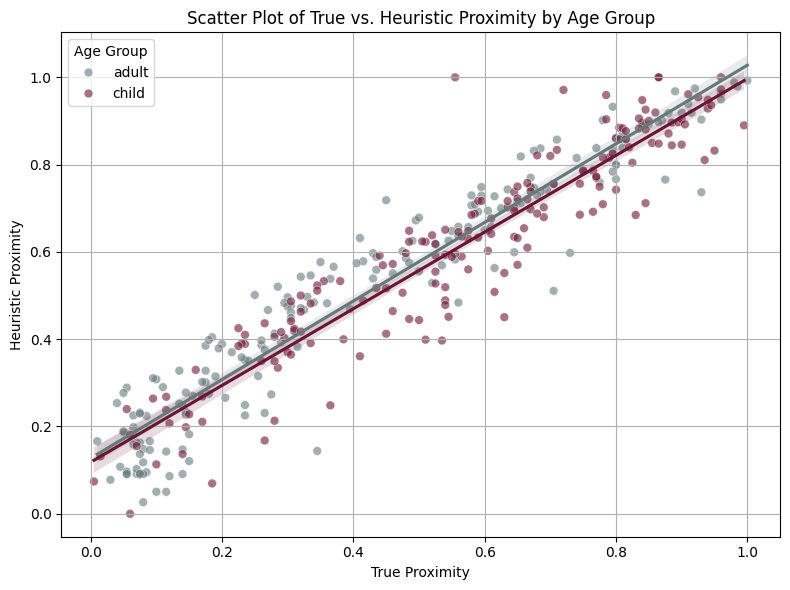

In [4]:
# Combined metrics
calculate_metrics(proximity_eval_df_clean, "Combined", "combined")

# Metrics for adults
calculate_metrics(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'adult'], "Adults", "combined")

# Metrics for children
calculate_metrics(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'child'], "Children", "combined")

# Visualize with regression line and color by age group
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='proximity_true',
    y='proximity_heuristic',
    hue='age_group',  # Color points by age group
    palette={'adult': '#66787C', 'child': '#691633'},  # Custom colors in hex format
    data=proximity_eval_df_clean,
    alpha=0.6,  # Transparency for points
    s=40  # Size of points
)

# Add regression lines for each group
sns.regplot(
    x='proximity_true',
    y='proximity_heuristic',
    data=proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'adult'],
    scatter=False,
    color='#66787C',  # Match adult color
)
sns.regplot(
    x='proximity_true',
    y='proximity_heuristic',
    data=proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'child'],
    scatter=False,
    color='#691633',  # Match child color
)

# Add plot labels and legend
plt.title('Scatter Plot of True vs. Heuristic Proximity by Age Group')
plt.xlabel('True Proximity')
plt.ylabel('Heuristic Proximity')
plt.legend(title='Age Group')
plt.grid(True)
plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_eval_plot.png', dpi=600)
plt.show()